In [2]:
libs <- c(
    'RColorBrewer',
    'ggplot2',
    'xgboost',
    'glmnet',
    'dplyr',
    'tidyr',
    'pROC',
    'ROCR',
    'stringr',
    'caret',
    'caTools'
)

for (lib in libs) {
        if (!require(lib, character.only = TRUE, quietly = TRUE)) {
            install.packages(lib, repos='http://cran.us.r-project.org')
        }
}

(.packages())

source("my_R_functions/utility_functions.R")
source("my_R_functions/stat_functions.R")
source("my_R_functions/plot_functions.R")
source("/ssd/mrichard/github/BDDS/trenadb/src/utils.R")
source("/ssd/mrichard/github/BDDS/footprints/testdb/src/dbFunctions.R")

[1] "RUnit"         "GenomicRanges" "GenomeInfoDb"  "IRanges"      
 [5] "S4Vectors"     "BiocGenerics"  "parallel"      "stats4"       
 [9] "RPostgreSQL"   "DBI"           "caTools"       "caret"        
[13] "lattice"       "stringr"       "ROCR"          "gplots"       
[17] "pROC"          "tidyr"         "dplyr"         "glmnet"       
[21] "foreach"       "Matrix"        "xgboost"       "ggplot2"      
[25] "RColorBrewer"  "stats"         "graphics"      "grDevices"    
[29] "utils"         "datasets"      "methods"       "base"

In [3]:
gbdt <- xgb.load("saved_models/xgboost_TF_site_predict.model")

In [4]:
load("Rdata_files/motif_class_pairs.Rdata")
load("/ssd/mrichard/data/all.TF.df.fimo.hint.well.annotated.9.Rdata")

In [5]:
cols_to_drop <- c('motifname', 'chrom', 'start', 'endpos', 'strand', 'pval', 'sequence')

In [6]:
colnames(all.TF.df.fimo.hint.well.annotated) <- make.names(colnames(all.TF.df.fimo.hint.well.annotated), unique=TRUE)

all.TF.df.fimo.hint.well.annotated %>%
    filter(h_frac > 0 | w_frac > 0 | cs_hit > 0) ->
    df_only_footprint_hits

In [7]:
df_only_footprint_hits %>%
    filter(chrom %in% c("2","4")) %>%
    select(-one_of(cols_to_drop)) ->
    val_df

val_df %>% 
    select(-cs_hit) %>%
    as.matrix ->
    X_val

val_df %>% 
    select(cs_hit) %>%
    as.matrix ->
    y_val

remove(all.TF.df.fimo.hint.well.annotated, df_only_footprint_hits, val_df)

In [8]:
colnames(X_val)

[1] "motifscore"                              
 [2] "h_max_score"                             
 [3] "w_min_score"                             
 [4] "h_frac"                                  
 [5] "w_frac"                                  
 [6] "gc_content"                              
 [7] "asinh_tss_dist"                          
 [8] "Basic.helix.loop.helix.factors..bHLH."   
 [9] "Basic.leucine.zipper.factors..bZIP."     
[10] "C2H2.zinc.finger.factors"                
[11] "Fork.head...winged.helix.factors"        
[12] "Heteromeric.CCAAT.binding.factors"       
[13] "High.mobility.group..HMG..domain.factors"
[14] "Homeo.domain.factors"                    
[15] "MADS.box.factors"                        
[16] "Nuclear.receptors.with.C4.zinc.fingers"  
[17] "Other.C4.zinc.finger.type.factors"       
[18] "Paired.box.factors"                      
[19] "Rel.homology.region..RHR..factors"       
[20] "Runt.domain.factors"                     
[21] "SMAD.NF.1.DNA.binding.domain.factors"    
[22] "STAT.domain.factors"                     
[23] "TATA.binding.proteins"                   
[24] "Tryptophan.cluster.factors"

In [9]:
medium_pred_df <- make.pred.df.from.model(gbdt, X_val, y_val)
colnames(medium_pred_df)[1] <- "ChIPseq.bound"
medium_stat_df <- make.stats.df.from.preds(medium_pred_df)

In [10]:
medium_stat_df %>% head

,threshold,sensitivity,specificity,ppv,npv,accuracy,MattCC
0,0.00,1,0,0.5729347,NaN,0.5729347,0
0.01,0.01,1,0,0.5729347,NaN,0.5729347,0
0.02,0.02,1,0,0.5729347,NaN,0.5729347,0
0.03,0.03,1,0,0.5729347,NaN,0.5729347,0
0.04,0.04,1,0,0.5729347,NaN,0.5729347,0
0.05,0.05,1,0,0.5729347,NaN,0.5729347,0


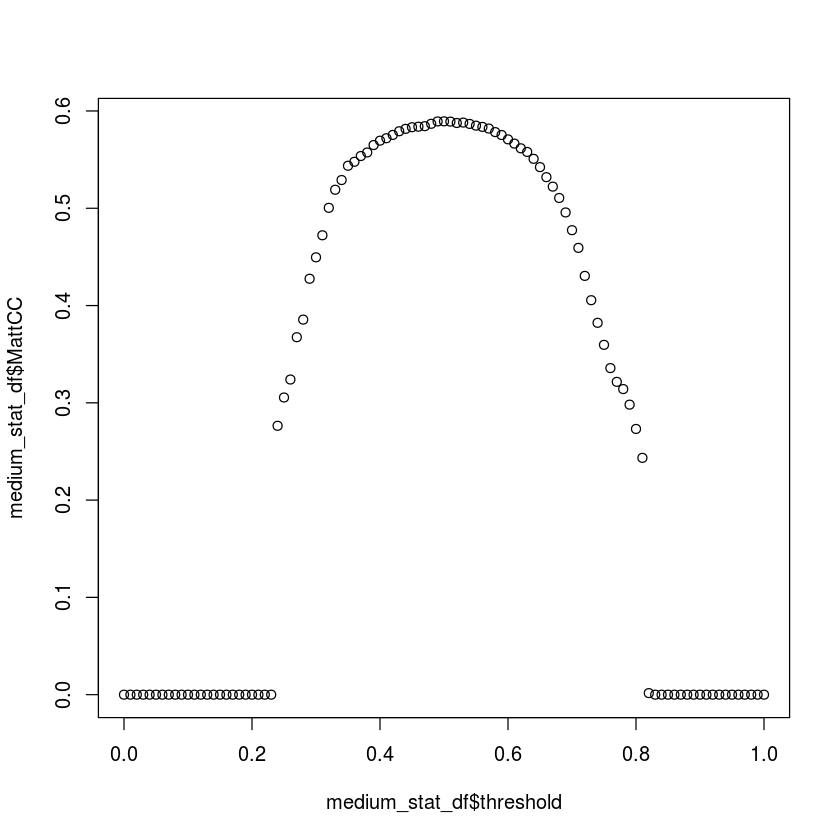

In [11]:
plot(medium_stat_df$threshold,medium_stat_df$MattCC)